In [1]:
import subprocess
import os
import pandas as pd
import numpy as np
import pylab as plt
import re
import SimpleITK as sitk
import matplotlib.pyplot as plt

import seaborn as sns
import preprocessing as pss
import gui
from protoclass.data_management import T2WModality
from protoclass.preprocessing import RicianNormalization
from protoclass.preprocessing import GaussianNormalization
from scipy.stats import rice

### Load findings and informations about images

In [2]:
df_images = pd.read_csv('data/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv')
df_findings = pd.read_csv('data/ProstateX-TrainingLesionInformationv2/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv')

In [3]:
df_images['DCMSerDescr'].value_counts().head(10)


ep2d_diff_tra_DYNDIST             795
t2_tse_tra                        412
t2_tse_sag                        358
t2_tse_cor                        339
tfl_3d PD ref_tra_1.5x1.5_t3      326
tfl_3d dynamisch fast             315
ep2d_diff_tra_DYNDIST_ADC         265
ep2d_diff_tra_DYNDISTCALC_BVAL    265
ep2d_diff_tra_DYNDIST_MIX         192
t2_loc sag                        151
Name: DCMSerDescr, dtype: int64

#### Select all T2W findings

In [4]:
T2W = df_images[df_images['DCMSerDescr'] == 't2_tse_tra']

In [21]:
t2w_mod = T2WModality()
t2w_mod.read_data_from_path(T2W[T2W['ProxID'] == 'ProstateX-0025'].iloc[0]['path'])

In [30]:
image = pss.read_dicom_series(T2W[T2W['ProxID'] == 'ProstateX-0025'].iloc[0]['path'])

In [32]:
pt = [34.8707, 51.5015, -3.06943]
print("Point {} is voxel {}.".format(
    pt, image.TransformPhysicalPointToIndex(pt)))

Point [34.8707, 51.5015, -3.06943] is voxel (265, 200, 26).


### Create paths to image files

In [5]:
ROOT_PATH = "C:\\FRANTISEK\\SKOLA FIIT\\bakalarka\\DATA\\PROSTATEx"

def get_path(row):
    
    # get path to infividual patient 
    DICOM_PATH = os.path.join(ROOT_PATH, str(row['ProxID']))
    # list all directories in patient directory
    patient_dirs = os.listdir(DICOM_PATH)
    # join first dir with prefix
    DICOM_PATH = os.path.join(DICOM_PATH,patient_dirs[0])
    # list all directories that contain dicom series
    series_dirs = os.listdir(DICOM_PATH)
    # find directory 
    final_dir = list(filter(lambda x: x.startswith( str(row['DCMSerNum']) ),series_dirs))
    if(len(final_dir) > 1):
        print(row['ProxID'])
    # get the final path 
    DICOM_PATH = os.path.join(DICOM_PATH,final_dir[0])
    
    return DICOM_PATH

#### Transform image

In [7]:
new_df = pd.DataFrame()
modality = T2W

for index,row in df_findings.iterrows():
    
    imgs_info = modality[(modality['ProxID']==row['ProxID'])
                              & (modality['fid']==row['fid']) 
                              & (modality['pos']==row['pos'])]
    
    if imgs_info.shape[0] == 0:
        continue
    
    
    # get the coordinates of finding
    ijk = [ int(x) for x in  imgs_info.iloc[0]['ijk'].split()]
    # lead dicom image
    path = get_path(imgs_info.iloc[0])
    t2w_mod = T2WModality()
    t2w_mod.read_data_from_path(path)
    #normalize image
    
    t2w_norm = GaussianNormalization(T2WModality())
    t2w_norm.fit(t2w_mod)
    t2w_mod = t2w_norm.normalize(t2w_mod)
    
    # extract region of interest
    roi, out = pss.extract_roi(t2w_mod.data_, ijk, [64,64,0])
    # find the zone of finding
    
    if not out:
        print('finding out of image')
        continue
    
    # new name 
    postfix = str(row['ProxID']) + '_' + str(row['fid']) + '_'+ str(row['zone']) +'.nii'
    file_name = './data/t2w/'+ postfix
    
    print(file_name)
    
    row['name'] = postfix
    new_df = new_df.append(row, ignore_index=True)
    
    pss.save_image(roi,file_name)

new_df = new_df.drop_duplicates()
new_df = new_df.reset_index()
new_df.to_csv('./data/t2w/info.csv')

False
1118
False
1118
./data/t2w/ProstateX-0000_1_PZ.nii
False
1258
False
1258
./data/t2w/ProstateX-0001_1_AS.nii
False
1086
False
1086
./data/t2w/ProstateX-0002_1_PZ.nii
False
1086
False
1086
./data/t2w/ProstateX-0002_2_PZ.nii
False
991
False
991
./data/t2w/ProstateX-0003_1_TZ.nii
False
991
False
991
./data/t2w/ProstateX-0003_2_TZ.nii
False
1432
False
1432
./data/t2w/ProstateX-0004_1_AS.nii
False
999
False
999
./data/t2w/ProstateX-0005_0_PZ.nii
False
999
False
999
./data/t2w/ProstateX-0005_1_PZ.nii
False
999
False
999
./data/t2w/ProstateX-0005_1_TZ.nii
False
1067
False
1067
./data/t2w/ProstateX-0006_1_PZ.nii
False
1067
False
1067
./data/t2w/ProstateX-0006_2_PZ.nii
False
1153
False
1153
./data/t2w/ProstateX-0007_1_TZ.nii
False
1048
False
1048
./data/t2w/ProstateX-0008_1_PZ.nii
False
1058
False
1058
./data/t2w/ProstateX-0009_1_TZ.nii
False
1041
False
1041
./data/t2w/ProstateX-0010_1_PZ.nii
False
1283
False
1283
./data/t2w/ProstateX-0011_1_PZ.nii
False
1000
False
1000
./data/t2w/Prostate

False
975
False
975
./data/t2w/ProstateX-0101_1_AS.nii
False
975
False
975
./data/t2w/ProstateX-0101_2_PZ.nii
False
1249
False
1249
./data/t2w/ProstateX-0102_1_TZ.nii
False
1309
False
1309
./data/t2w/ProstateX-0103_1_PZ.nii
False
1309
False
1309
./data/t2w/ProstateX-0103_2_PZ.nii
False
1224
False
1224
./data/t2w/ProstateX-0104_1_AS.nii
False
1224
False
1224
./data/t2w/ProstateX-0104_2_PZ.nii
False
1125
False
1125
./data/t2w/ProstateX-0105_1_TZ.nii
False
1125
False
1125
./data/t2w/ProstateX-0105_2_TZ.nii
False
1125
False
1125
./data/t2w/ProstateX-0105_3_SV.nii
False
1057
False
1057
./data/t2w/ProstateX-0106_1_PZ.nii
False
1057
False
1057
./data/t2w/ProstateX-0106_2_AS.nii
False
1232
False
1232
./data/t2w/ProstateX-0107_1_TZ.nii
False
1402
False
1402
./data/t2w/ProstateX-0108_1_PZ.nii
False
1402
False
1402
./data/t2w/ProstateX-0108_2_TZ.nii
False
1038
False
1038
./data/t2w/ProstateX-0109_1_TZ.nii
False
1038
False
1038
./data/t2w/ProstateX-0109_2_TZ.nii
False
1082
False
1082
./data/t2w/Pr

False
1480
False
1480
./data/t2w/ProstateX-0181_1_AS.nii
False
900
False
900
./data/t2w/ProstateX-0182_1_PZ.nii
False
1075
False
1075
./data/t2w/ProstateX-0183_1_PZ.nii
False
1378
False
1378
./data/t2w/ProstateX-0184_1_PZ.nii
False
1378
False
1378
./data/t2w/ProstateX-0184_2_PZ.nii
False
984
False
984
./data/t2w/ProstateX-0185_1_TZ.nii
False
1354
False
1354
./data/t2w/ProstateX-0186_1_AS.nii
False
1354
False
1354
./data/t2w/ProstateX-0186_2_PZ.nii
False
1027
False
1027
./data/t2w/ProstateX-0187_1_AS.nii
False
1027
False
1027
./data/t2w/ProstateX-0187_2_TZ.nii
False
1027
False
1027
./data/t2w/ProstateX-0187_4_AS.nii
False
1094
False
1094
./data/t2w/ProstateX-0188_1_PZ.nii
False
851
False
851
./data/t2w/ProstateX-0189_1_PZ.nii
False
851
False
851
./data/t2w/ProstateX-0189_2_PZ.nii
False
851
False
851
./data/t2w/ProstateX-0189_3_PZ.nii
False
1261
False
1261
./data/t2w/ProstateX-0190_1_PZ.nii
False
1261
False
1261
./data/t2w/ProstateX-0190_2_PZ.nii
False
1487
False
1487
./data/t2w/Prostate

# Rest

In [7]:
# path = get_path(a.iloc[0])
t2w_mod = T2WModality()
t2w_mod.read_data_from_path('C:\\FRANTISEK\\SKOLA FIIT\\bakalarka\\DATA\\PROSTATEx\\ProstateX-0003\\10-17-2011-MC prostaat kliniek detectie-mc MCPROSKL30-03010\\3-t2tsetra-30967')

False
991


In [100]:
a = T2W[T2W['ProxID'] == 'ProstateX-0003']

In [122]:
get_path(a.iloc[0])

'C:\\FRANTISEK\\SKOLA FIIT\\bakalarka\\DATA\\PROSTATEx\\ProstateX-0003\\10-17-2011-MC prostaat kliniek detectie-mc MCPROSKL30-03010\\3-t2tsetra-30967'

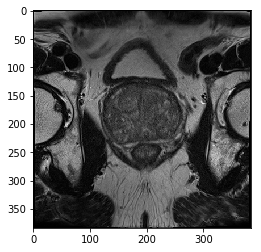

In [120]:
plt.imshow(t2w_mod.data_[:,:,9],cmap = 'gray')

In [123]:

np.histogram(t2w_mod.data_,
             bins= t2w_mod.nb_bins_,
             density=True)

(array([2.17314221e-02, 1.14997985e-03, 7.60517423e-04, 6.97544643e-04,
        7.27900752e-04, 7.90227658e-04, 8.39314133e-04, 9.37810020e-04,
        1.02952422e-03, 1.10832093e-03, 1.18840939e-03, 1.30014571e-03,
        1.44998863e-03, 1.56656901e-03, 1.76033141e-03, 1.87465123e-03,
        2.01125372e-03, 2.19209863e-03, 2.33548280e-03, 2.52020296e-03,
        2.66035776e-03, 2.74722791e-03, 2.91418651e-03, 3.00686952e-03,
        3.15800420e-03, 3.24584315e-03, 3.35790241e-03, 3.40569713e-03,
        3.52712157e-03, 3.69795542e-03, 3.73832259e-03, 3.82939091e-03,
        3.89365544e-03, 4.00410001e-03, 4.05060299e-03, 4.06836454e-03,
        4.16233931e-03, 4.17331918e-03, 4.25114707e-03, 4.20109179e-03,
        4.17235036e-03, 4.31541160e-03, 4.33026672e-03, 4.33026672e-03,
        4.33381903e-03, 4.31605748e-03, 4.40970930e-03, 4.26406457e-03,
        4.31928685e-03, 4.21045697e-03, 4.29603536e-03, 4.25276176e-03,
        4.20561291e-03, 4.11454458e-03, 4.20884228e-03, 4.129076

In [130]:
x = np.array([[1,2,3,4],
              [2,3,np.nan,5],
              [np.nan,5,2,3]])
np.isnan(t2w_mod.max_int_).any()

AttributeError: 'T2WModality' object has no attribute 'max_int_'

In [15]:
t2w_norm.fit_params_

{'b': 41.44280030816054,
 'off': -11.204795034901975,
 'sigma': 0.2686474256263317}

In [12]:
a = rice.mean(t2w_norm.fit_params_['b'],
                                    t2w_norm.fit_params_['off'],
                                    t2w_norm.fit_params_['sigma']) 

In [13]:
a

nan

In [135]:
t2w_mod.max_

nan

In [ ]:
t2w_mod.data_ -= rice.mean(self.fit_params_['b'],
                                    self.fit_params_['off'],
                                    self.fit_params_['sigma']) * self.max_int

In [86]:
i = 0
for indx , row in df_findings.iterrows():
    finding = T2W[(T2W['ProxID']==row['ProxID']) 
                  & (T2W['fid']==row['fid']) 
                  & (T2W['pos']==row['pos'])
                  ]
   
    if finding.shape[0] > 1:
        print(finding)
        i += 1 
i

            ProxID         Name  fid  \
19  ProstateX-0001  t2_tse_tra0    1   
20  ProstateX-0001  t2_tse_tra0    1   

                                                  pos  \
19  -40.5367071921656 29.320722668457 -16.70766907...   
20  -40.5367071921656 29.320722668457 -16.70766907...   

                                          WorldMatrix         ijk  TopLevel  \
19  0.5,1.02552e-010,-4.64581e-017,-119.205,-1.019...  157 186 10       1.0   
20  0.5,1.02552e-010,-4.64581e-017,-119.205,-1.019...  157 186 10       1.0   

    SpacingBetweenSlices VoxelSpacing           Dim DCMSerDescr  DCMSerNum  
19                   3.0    0.5,0.5,3  384x384x19x1  t2_tse_tra          6  
20                   3.0    0.5,0.5,3  384x384x19x1  t2_tse_tra         10  
             ProxID         Name  fid                       pos  \
166  ProstateX-0010  t2_tse_tra0    1  -31.8128 51.364 -56.0047   
167  ProstateX-0010  t2_tse_tra0    1  -31.8128 51.364 -56.0047   

                                    

             ProxID         Name  fid                       pos  \
701  ProstateX-0042  t2_tse_tra0    1  0.258727 12.1867 29.2257   
702  ProstateX-0042  t2_tse_tra0    1  0.258727 12.1867 29.2257   

                                           WorldMatrix        ijk  TopLevel  \
701  0.5,1.02552e-010,3.31536e-017,-104.747,-9.7751...  210 174 7       NaN   
702  0.5,1.02552e-010,3.31536e-017,-104.747,-9.7751...  210 174 7       NaN   

     SpacingBetweenSlices VoxelSpacing           Dim DCMSerDescr  DCMSerNum  
701                   3.0    0.5,0.5,3  384x384x25x1  t2_tse_tra          4  
702                   3.0    0.5,0.5,3  384x384x25x1  t2_tse_tra          9  
             ProxID         Name  fid                      pos  \
813  ProstateX-0052  t2_tse_tra0    1  26.6078 10.1553 50.5636   
814  ProstateX-0052  t2_tse_tra0    1  26.6078 10.1553 50.5636   

                                           WorldMatrix         ijk  TopLevel  \
813  0.5,1.02552e-010,2.18148e-017,-79.6872,-1.

              ProxID         Name  fid                      pos  \
1903  ProstateX-0123  t2_tse_tra0    1  20.8643 30.9437 29.9455   
1904  ProstateX-0123  t2_tse_tra0    1  20.8643 30.9437 29.9455   

                                            WorldMatrix        ijk  TopLevel  \
1903  0.5,1.02552e-010,1.40962e-016,-83.3017,-1.0089...  208 227 7       NaN   
1904  0.5,1.02552e-010,1.40962e-016,-83.3017,-1.0089...  208 227 7       NaN   

      SpacingBetweenSlices VoxelSpacing           Dim DCMSerDescr  DCMSerNum  
1903                   3.0    0.5,0.5,3  384x384x21x1  t2_tse_tra          5  
1904                   3.0    0.5,0.5,3  384x384x21x1  t2_tse_tra         10  
              ProxID         Name  fid                        pos  \
1924  ProstateX-0125  t2_tse_tra0    1  -37.3152 28.8733 -27.9854   
1925  ProstateX-0125  t2_tse_tra0    1  -37.3152 28.8733 -27.9854   

                                            WorldMatrix         ijk  TopLevel  \
1924  0.5,1.02552e-010,4.40422e

              ProxID         Name  fid                      pos  \
2443  ProstateX-0149  t2_tse_tra0    1  19.0337 63.5321 14.5746   
2445  ProstateX-0149  t2_tse_tra0    1  19.0337 63.5321 14.5746   

                                            WorldMatrix        ijk  TopLevel  \
2443  0.5,1.02552e-010,1.14023e-016,-82.5788,-9.6964...  203 237 9       NaN   
2445  0.5,1.02552e-010,1.14023e-016,-82.5788,-9.6964...  203 237 9       NaN   

      SpacingBetweenSlices VoxelSpacing           Dim DCMSerDescr  DCMSerNum  
2443                   3.0    0.5,0.5,3  384x384x19x1  t2_tse_tra          4  
2445                   3.0    0.5,0.5,3  384x384x19x1  t2_tse_tra          9  
              ProxID         Name  fid                     pos  \
2444  ProstateX-0149  t2_tse_tra0    2  3.5212 62.8315 14.8159   
2446  ProstateX-0149  t2_tse_tra0    2  3.5212 62.8315 14.8159   

                                            WorldMatrix        ijk  TopLevel  \
2444  0.5,1.02552e-010,1.14023e-016,-82.5

              ProxID         Name  fid                        pos  \
2897  ProstateX-0173  t2_tse_tra0    1  -19.6271 40.7648 -22.8634   
2899  ProstateX-0173  t2_tse_tra0    1  -19.6271 40.7648 -22.8634   
2901  ProstateX-0173  t2_tse_tra0    1  -19.6271 40.7648 -22.8634   

                                            WorldMatrix         ijk  TopLevel  \
2897  0.5,1.02552e-010,5.89287e-017,-98.0005,-9.3318...  157 178 13       NaN   
2899  0.5,1.02552e-010,5.89287e-017,-98.0005,-9.3318...  157 178 13       NaN   
2901  0.6,1.23062e-010,5.89287e-017,-98.0505,-1.1198...  131 148 13       NaN   

      SpacingBetweenSlices VoxelSpacing           Dim DCMSerDescr  DCMSerNum  
2897                   3.0    0.5,0.5,3  384x384x21x1  t2_tse_tra          5  
2899                   3.0    0.5,0.5,3  384x384x21x1  t2_tse_tra          9  
2901                   3.0    0.6,0.6,3  320x320x21x1  t2_tse_tra         57  
              ProxID         Name  fid                        pos  \
2896  Prostat

80